In [57]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import signal
from sporco import fft
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()
from sporco.cupy import (cupy_enabled, np2cp, cp2np, select_device_by_load,
                         gpu_info)
from sporco.cupy.admm import cbpdn

In [58]:
def pad(x, n=8):

    if x.ndim == 2:
        return np.pad(x, n, mode='symmetric')
    else:
        return np.pad(x, ((n, n), (n, n), (0, 0)), mode='symmetric')


def crop(x, n=8):

    return x[n:-n, n:-n]

In [59]:
img = util.ExampleImages().image('e.jpg', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, :])
np.random.seed(12345)
imgn = img + np.random.normal(0.0, 0.3, img.shape).astype(np.float32)

In [60]:
npd = 16
fltlmbd = 5.0
imgnl, imgnh = signal.tikhonov_filter(imgn, fltlmbd, npd)

In [61]:
D = util.convdicts()['G:8x8x128']

In [62]:
imgnpl, imgnph = signal.tikhonov_filter(pad(imgn), fltlmbd, npd)
W = fft.irfftn(np.conj(fft.rfftn(D[..., np.newaxis, :], imgnph.shape[0:2],
               (0, 1))) * fft.rfftn(imgnph[..., np.newaxis], None, (0, 1)),
               imgnph.shape[0:2], (0, 1))
W = 1.0/(np.maximum(np.abs(W), 1e-8))

lmbda = 1.5e-2
mu = 2.7e-1

opt = cbpdn.ConvBPDNJoint.Options({'Verbose': True, 'MaxMainIter': 250,
            'HighMemSolve': True, 'RelStopTol': 3e-3, 'AuxVarObj': False,
            'L1Weight': np2cp(W), 'AutoRho': {'Enabled': False},
            'rho': 1e3*lmbda})

In [63]:
if not cupy_enabled():
    print('CuPy/GPU device not available: running without GPU acceleration\n')
else:
    id = select_device_by_load()
    info = gpu_info()
    if info:
        print('Running on GPU %d (%s)\n' % (id, info[id].name))

b = cbpdn.ConvBPDNJoint(np2cp(D), np2cp(pad(imgnh)), lmbda, mu, opt, dimK=0)
X = cp2np(b.solve())

CuPy/GPU device not available: running without GPU acceleration

Itn   Fnc       DFid      Regℓ1     Regℓ2,1   r         s       
----------------------------------------------------------------
   0  4.00e+04  7.99e+02  1.96e+06  3.65e+04  9.70e-01  8.22e-02
   1  2.16e+04  2.77e+03  8.48e+05  2.26e+04  8.53e-01  1.56e-01
   2  1.64e+04  3.28e+03  5.55e+05  1.77e+04  3.83e-01  1.99e-01
   3  1.82e+04  3.09e+03  6.74e+05  1.84e+04  2.17e-01  1.78e-01
   4  1.80e+04  2.62e+03  6.67e+05  2.00e+04  1.45e-01  1.32e-01
   5  1.55e+04  2.30e+03  5.29e+05  1.95e+04  1.05e-01  1.03e-01
   6  1.29e+04  2.14e+03  3.91e+05  1.81e+04  8.21e-02  8.80e-02
   7  1.10e+04  2.09e+03  2.93e+05  1.69e+04  6.74e-02  7.55e-02
   8  1.01e+04  2.09e+03  2.44e+05  1.60e+04  5.64e-02  6.48e-02
   9  9.51e+03  2.10e+03  2.16e+05  1.55e+04  4.77e-02  5.68e-02
  10  9.02e+03  2.10e+03  1.89e+05  1.51e+04  4.07e-02  5.11e-02
  11  8.76e+03  2.09e+03  1.75e+05  1.49e+04  3.52e-02  4.67e-02
  12  8.45e+03  2.08e+03 

In [64]:
imgdp = cp2np(b.reconstruct().squeeze())
imgd = np.clip(crop(imgdp) + imgnl, 0, 1)

In [65]:
print("ConvBPDNJoint solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % metric.psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % metric.psnr(img, imgd))

ConvBPDNJoint solve time: 12038.58 s
Noisy image PSNR:    10.80 dB
Denoised image PSNR: 16.37 dB


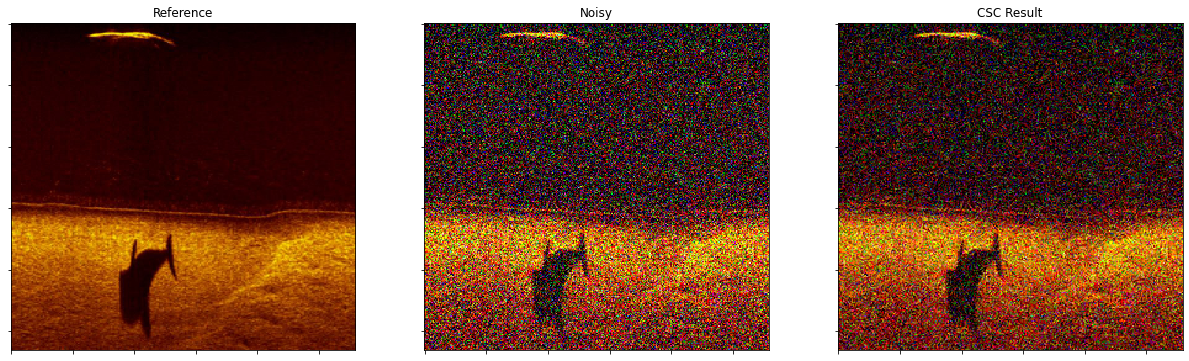

In [66]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, title='Reference', fig=fig)
plot.subplot(1, 3, 2)
plot.imview(imgn, title='Noisy', fig=fig)
plot.subplot(1, 3, 3)
plot.imview(imgd, title='CSC Result', fig=fig)
fig.show()

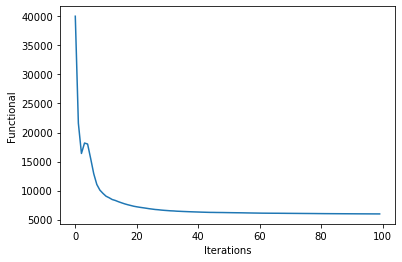

In [67]:
its = b.getitstat()
ObjFun = [float(x) for x in its.ObjFun]
plot.plot(ObjFun, xlbl='Iterations', ylbl='Functional')

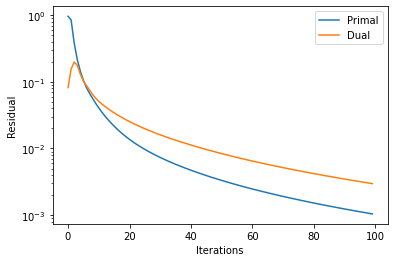

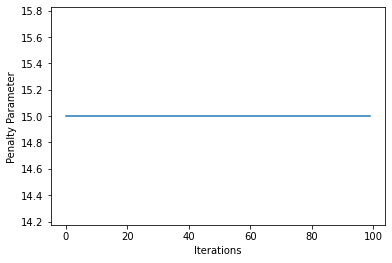

In [68]:
PrimalRsdl = [float(x) for x in its.PrimalRsdl]
DualRsdl = [float(x) for x in its.DualRsdl]
plot.plot(np.vstack((PrimalRsdl, DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')

In [69]:
from skimage.metrics import structural_similarity as ssim
ssim_const_1 = ssim(img, imgd,
                  data_range=imgd.max() - imgd.min(), multichannel=True)

print(ssim_const_1)#structure similarity between two random variables -it measures contrast,variance,mean, luminous,covariance 

0.07612242752650084
